# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

---

**Задачи исследования:**

1. Загрузить и подготовить данные.
2. Обучить модели. 
3. Сделайте выводы.

---

**Цель исследования** - построить модель для классификации комментариев на позитивные и негативные.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 
- *text* — текст комментария
- *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install catboost -q
!pip install spacy -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re 

import spacy
!spacy download en_core_web_sm -q

plt.rcParams["figure.figsize"] = (15,10)

from pymystem3 import Mystem

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords as nltk_stopwords

from sklearn.pipeline import (
    Pipeline,
    make_pipeline)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#warnings.filterwarnings("ignore")

In [4]:
#Объявим константы

RANDOM_STATE = 42

### Загрузка данных

In [5]:
pth = '/datasets/toxic_comments.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
else:
    print('Something is wrong')

### Изучение общей информации

In [6]:
#Выведем первые строки датафрейма
display(data.head())
print('*' * 125)

#Выведем общую информацию
data.info()
print('*' * 125)

#Выведем описание данных
display(data.describe().T)
print('*' * 125)

print('Количество явных дубликатов в датафрейте:', data.duplicated().sum())
print('Количество пропусков в датафрейте:', data.isna().sum())

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


*****************************************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
*****************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0


*****************************************************************************************************************************
Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [7]:
#Столбец Unnamed неинформативен (дублирует индексы), удалим его
data = data.drop('Unnamed: 0', axis=1)
data.head(1)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0


In [8]:
#Убедимся, что не появились новые дубликаты
print('Количество явных дубликатов в датафрейте:', data.duplicated().sum())

Количество явных дубликатов в датафрейте: 0


**Вывод** Данные в датасете соответствуют описанию.

Количество сток - 159 292, Количество столбцов - 2. 

Тип данных указан верно, пропусков и дубликатов в датафрейме нет, название столбцов сответсвуют стилю написания snake_case 

### Анализ и подготовка данных

####  text

In [9]:
data.head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Видим, что комментарии написаны на английском языке. Для комментариев используется разный регистр и неинформативные знаки. Сделаем копию датасета и приведем данные к единому формату

In [10]:
data_ml = data.copy()

In [11]:
# Добавим столбец длина стоки
data_ml['len'] = data_ml['text'].apply(len)
data_ml.head()

,text,toxic,len
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,264
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,112
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,233
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,622
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,67


In [12]:
data_ml['len'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: len, dtype: float64

In [13]:
#Выведем самые длинные комментарии
data_ml.sort_values(by='len').tail()

text  \
12869   I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I 

Видим, что длина самых длинных комментариев ограничена 5000 знаков. Также стоит обратить внимание, что текст послания не большой, но дублируется много раз.

In [14]:
#Выведем самые короткие комментарии
data_ml.sort_values(by='len').head(15)

,text,toxic,len
119018,"""""""",1,5
137400,"== """"""",0,6
52336,"14:53,",0,6
136820,~ J.Lo,0,6
15432,"Howdy!""",0,7
120868,you suck,1,8
109794,{{unbloc,0,8
118650,FUCK YOU,1,8
150648,"04:59, 22 Au",0,12
93421,{{unblock|yo,0,12


Видим, что комментарии менее 6 символов неинформативны

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


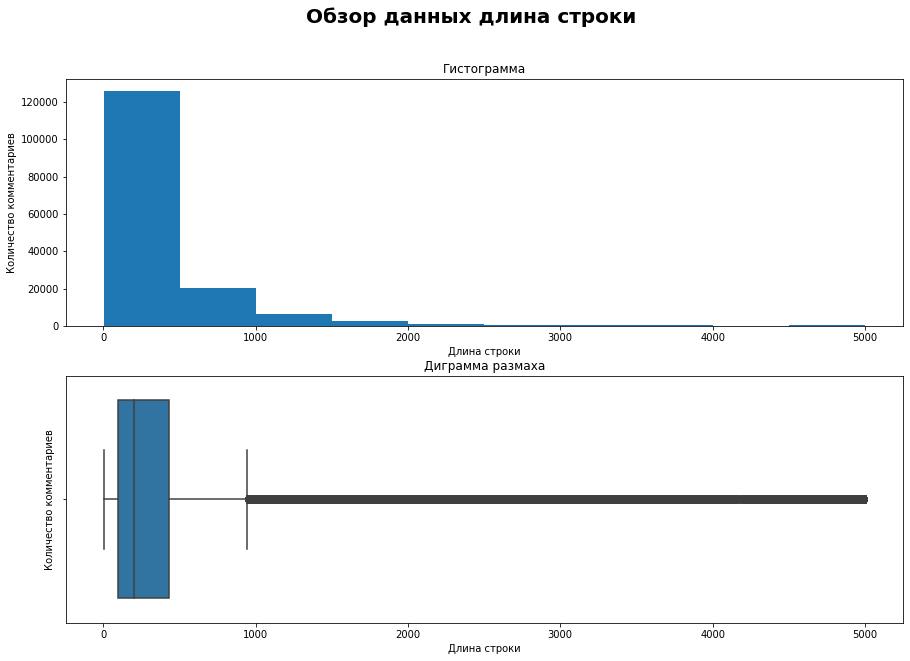

In [15]:
# Построим графики распределения признака len
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'Обзор данных длина строки', fontsize = 20, fontweight='bold')
    
data_ml['len'].plot(ax=ax[0], kind='hist')
     
sns.boxplot(data_ml['len'], ax=ax[1])
    
ax[0].set_title('Гистограмма')
ax[0].set_xlabel('Длина строки')
ax[0].set_ylabel('Количество комментариев')

    
ax[1].set_title('Диграмма размаха')
ax[1].set_xlabel('Длина строки')
ax[1].set_ylabel('Количество комментариев')

plt.show()

In [16]:
#Процент выбросов в столбце длина строки
print('Количество выбросов, составляет:', data_ml[data_ml['len'] > 1000].shape[0])
print('Доля выбросов, составляет:', round(data_ml[data_ml['len'] > 1000].shape[0]/data_ml.shape[0], 2))

Количество выбросов, составляет: 13324
Доля выбросов, составляет: 0.08


Длина комментария выше 1000 знаков реалистична по значению, поэтому считать выбросами данные комментарии мы не можем. Посмотрим сколько комментариев длиною 5000 символов.

In [17]:
#Процент выбросов (количество символов равно 5000 знаков) в столбце длина строки
print('Количество выбросов, составляет:', data_ml[data_ml['len'] == 5000].shape[0])
print('Доля выбросов, составляет:', round(data_ml[data_ml['len'] == 5000].shape[0]/data_ml.shape[0], 4))

Количество выбросов, составляет: 42
Доля выбросов, составляет: 0.0003


In [18]:
#Процент выбросов (более 4500) в столбце длина строки
print('Количество выбросов, составляет:', data_ml[data_ml['len'] > 4500].shape[0])
print('Доля выбросов, составляет:', round(data_ml[data_ml['len'] > 4500].shape[0]/data_ml.shape[0], 4))

Количество выбросов, составляет: 638
Доля выбросов, составляет: 0.004


In [19]:
# Посмотрим на сообщения от 4500 символов
data_ml[data_ml['len'] > 4500].sort_values(by='len').head(10)

text  \
11166                                                                                        "I had nearly moved on when I felt completely compelled to comment on this statement ""probably better than most clan websites, which tend to be based on long outdated stuff from the 19th century. Then I do not see a problem in using it until a better source can be found. Especially to make amends to the masses of unsourced information that is found on so many of the individual clan articles"". I can only interpet this as something is probably better because it is newer?? This makes no sense to me. History is what it is, it should not change for the sake of change. If it was accurate over 600 years ago, it is just as accurate today. Again, if something is true and accurate hundreds or even thousands of years ago, it is not and should not be subject to change because someone decides to re-write it for either personal gain or an agenda. That is exactly what has happened with the origins for many Highland Clans. For any that might be interested, William Skene's and John Murray's collaboration of The Highlanders of Scotland: Their Origin, History and Antiquities is a wonderful and refreshing read. This is more than likely the truest accounting for several of the Highland Clans. It asserts that many of the origin claims put forth in more recent times are attempts to gain a foothold on the Chieftainship, by usurping the rightful lines. You'll find that cadet septs used this technique to basically try to re-write history for their own selfish gain. You'd have to read the book to see how this played out but as I said before, nearly ALL of the Highland Clans being ""bastardized"" as Norman/Anglo-Horman/Flemish, etc. are really Dalriadan and Pictish mixes. Examples would be Campbell, Cameron, Grant, Davidson, Wallace, etc. I of course have distant YDNA connections to ALL of these surnames, but I know no one wants to hear about that as any sort of evidence. I'll admit not one of these surnames or clans has a pure lineage, but they all have a lineage going back to the Picts and Gaels. I am of that lineage, which is quite rare and continues to be established. The masses are not of that lineage, they are a mix if R1A1, other R1B haplotypes, the I haplotypes, etc. I will be the first to admit there may be hundreds of families, not even related through a shared male ancestor, sharing a surname or Clan. My concern is with the origins only, and the original Chiefly lines. And please don't tell me how we are a mix of so much dna, I am only referring to YDNA, the male lines. I am not talking about MTDNA nor Autosomal. What I don't understand is why when there is so much sourced information out there, some editors choose only to use factually inaccurate ""sourced"" information. There is substantial ""factually accurate"" sourced information out there however it is not my intent, to correct these erroneous articles or to present an ""opposing view"". There is no opposing view, there is either the truth, or their are lies. Either the Celtic version is correct, or the Comyn version is correct, or neither is correct. There can't factually be multiple versions of an origin, it is what it is and there is only one true origin. This is not a contest to see who can provide more recent sources. I would hope wikipedia would want the truth out there, and not contests of who can out edit who, which is what wikipedia appears to be. There, my case is presented to the message and not a specific messenger. Clan Davidson is Celtic, it descended from Celts and it has no connection to the Comyn family. It did not descend from a Comyn male. They came from a very ancient Gaelic ancestor, an ancestor shared by several Highland Clans, before surnames even were in use. One other greatly incorrect update to this site was the battle alleged between the Davidson's and the MacPherson's....this never happened. The battle was between the Clans fighting for the Chief of the Clan 

Видим, что текст данных сообщений уникален, в нем пользователи высказывают подробно свое мнение. В отличии от комментариев на 5000 знаков, где пользователи копируют одну фразу много раз. 

Доля аномальных комментарии (длинной 5000 символов) всего 0,03% от всего датасета, на данном этапе удалять аномалии не будем, но будем иметь ввиду, что их можно будет удалить, для ускорения лемматизации текста. 

Проверим зависит ли токсичность комментариев от его длины. 

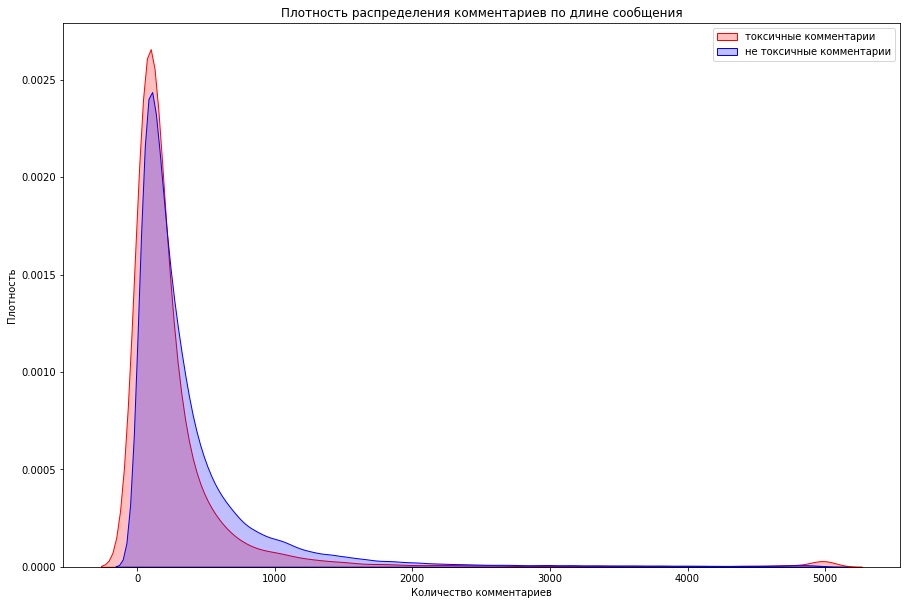

In [20]:
#Разобьем данные по признаку длина сообщения на токсичные и не токсичные комментарии.
data_ml_toxic = data_ml[data_ml['toxic'] == 1]['len']
data_ml_no_toxic = data_ml[data_ml['toxic'] == 0]['len']

#Пострим распределение 
plt.figure()
sns.kdeplot(data_ml_toxic, fill=True, color='red', label='токсичные комментарии')
sns.kdeplot(data_ml_no_toxic, fill=True, color='blue', label='не токсичные комментарии')
plt.title('Плотность распределения комментариев по длине сообщения')
plt.xlabel('Количество комментариев')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Из графика можем сделать вывод, что токсичность комментария не зависит от его длины.

**Очистка текста + лемматизация**

In [21]:
#Объявим лемматизатор
nlp = spacy.load("en_core_web_sm")

In [22]:
# Убедимся на простом примере, что он работает
sentence1 = "The striped bats are hanging on their feet for best//  "
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                      text
0  The striped bats are hanging on their feet for best//  
1            you should be ashamed of yourself went worked


In [23]:
def clear_text(text):
    #перевод текста в нижний регистр
    text = text.lower()
    # Удаление всех символов, кроме английских букв и пробелов
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Удаление лишних пробелов
    text = " ".join(text.split())
    return text

In [24]:
# Убедимся на простом примере, что он работает
lemm1 = []

for i in tqdm(range(len(df_my))):
    tokens = clear_text(df_my.text[i])
    tokens = nlp(tokens)
    lemm1.append(" ".join([token.lemma_ for token in tokens]))

df_my['lemm_text'] =  lemm1
df_my

100%|██████████| 2/2 [00:00<00:00, 100.03it/s]


,text,lemm_text
0,The striped bats are hanging on their feet for best//,the stripe bat be hang on their foot for good
1,you should be ashamed of yourself went worked,you should be ashamed of yourself go work


Лемматизатор работает (striped  ------> stripe, went -------> go), применим его для нашего датасета

In [25]:
lemm = []

for i in tqdm(range(len(data_ml))):
    tokens = clear_text(data_ml.text[i])
    tokens = nlp(tokens)
    lemm.append(" ".join([token.lemma_ for token in tokens]))

data_ml['lemm_text'] =  lemm
data_ml.head()

100%|██████████| 159292/159292 [39:16<00:00, 67.61it/s] 


,text,toxic,len,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,264,explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york doll fac and please don t remove the template from the talk page since I m retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,112,d aww he match this background colour I m seemingly stuck with thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,233,hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,622,more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,67,you sir be my hero any chance you remember what page that s on


Итак, мы привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам). Лемматизированный текст находится в столбце 'lemm_text'.

#### toxic

In [29]:
# найдем уникальные значения признака 'toxic'
data_ml['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

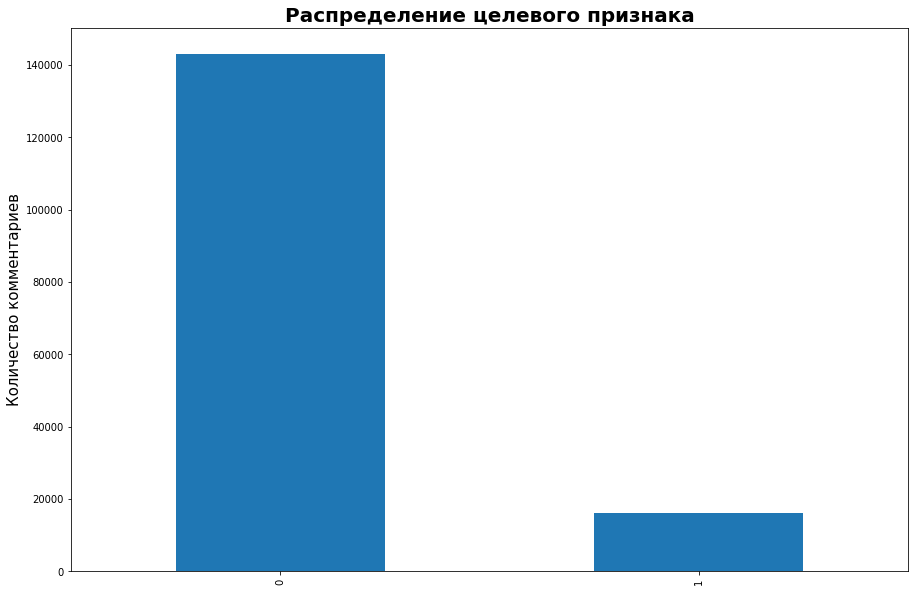

In [30]:
# проверим распределение классов
data_ml['toxic'].value_counts().plot.bar()
plt.title('Распределение целевого признака', fontsize = 20, fontweight='bold')
plt.ylabel('Количество комментариев', fontsize = 15)
plt.show()

На лицо дисбаланс классов, учтем это при разбиении данных на выборки

**Вывод**

На этапе анализа и подготовки данных:

Для признака text
- Видим, что комментарии написаны на английском языке. Для комментариев используется разный регистр и неинформативные знаки. Сделали копию датасета и привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам). Лемматизированный текст находится в столбце 'lemm_text'.
- Добавили признак, длина комментария. Определили, что длина самых длинных комментариев ограничена 5000 знаков. При этом стоит обратить внимание, что текст послания не большой, но дублируется много раз. Сделали вывод, что токсичность комментария не зависит от его длины.

Для признака toxic - целевой признак

- Содержит два значения 0 и 1.
- Выявили дисбаланс классов, учтем это при разбиении данных на выборки 

    

## Обучение

### Подготовка данных

In [31]:
#сохраним входные и целевой признаки
X = data_ml['lemm_text']
y = data_ml['toxic']

In [32]:
# разделим входные и целевой признаки на тренировочную и тестовую выборки в соотношении 80:20
# укажем stratify=y, т.к. необходимо сохранить соотношение классов при разделении
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433,), (31859,), (127433,), (31859,))

In [33]:
# Проверим на дисбаланс классов

print('Соотшошение токсичных комментариев к нетоксичным на train:', round((y_train == 1).sum() / (y_train == 0).sum(), 5))
print('Соотшошение токсичных комментариев к нетоксичным на test:', round((y_test == 1).sum() / (y_test == 0).sum(), 5))

Соотшошение токсичных комментариев к нетоксичным на train: 0.11311
Соотшошение токсичных комментариев к нетоксичным на test: 0.11309


In [34]:
# X_train = X_train.values.astype('U')
# X_test = X_test.values.astype('U')

In [35]:
# найдём стоп-слова (слова без смысловой нагрузки)
stopwords = list(nltk_stopwords.words('english'))

In [36]:
# создадим счётчик и передадим в него список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [37]:
# считаем величину TF-IDF

train_tf_idf = count_tf_idf.fit_transform(X_train)
test_tf_idf = count_tf_idf.transform(X_test)

In [38]:
print("Размер матрицы train:", train_tf_idf.shape)
print("Размер матрицы test:", test_tf_idf.shape)

Размер матрицы train: (127433, 132365)
Размер матрицы test: (31859, 132365)


**Вывод** На этапе подготовки данных к обучению модели разбили данные на тренировочную и тестовые выборки в соотношении 80:20 с учетом дисбаланса классов. Закодировали признаки с помощью TFIDF

### Обучение моделей

In [40]:
# #Определим функцию grid для подбора параметров
def grid(model, params):
    pipeline = Pipeline([('model', model)])    
    grid = GridSearchCV(
        pipeline, 
        cv = 5, 
        n_jobs = -1, 
        param_grid = params ,
        scoring = 'f1', 
        verbose = False)
    grid.fit(train_tf_idf, y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid   

In [41]:
#Логистическая регресия
log_reg = grid(LogisticRegression(), {"model__C":range(5,15), "model__penalty":["l1", "l2"]})

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучший результат: 0.7723446727352241
Лучшие параметры: {'model__C': 13, 'model__penalty': 'l2'}


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
#DecisionTreeClassifier
dec_tree = grid(DecisionTreeClassifier(), {'model__class_weight':['balanced'], 
                                           'model__max_depth':range(1,10), 
                                           'model__max_features': range(1,10)})

Лучший результат: 0.1853794987976634
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__max_features': 8}


In [43]:
#CatBoostClassifier
# cat_boost = grid(CatBoostClassifier(logging_level='Silent'), {'model__depth': [2, 4, 6],
#                  'model__learning_rate' : [0.05, 0.1],
#                   'model__iterations' : [50, 100]})

<div class="alert alert-info">
<h2> Комментарий<a class="tocSkip"> </h2>

На прошлом шаге подобрала лучшие параметры для модели CatBoostClassifier, сейчас уже запускаю функцию grid только для них, так она очень долго работает

</div>


In [44]:
#CatBoostClassifier
cat_boost = grid(CatBoostClassifier(logging_level='Silent'), {'model__depth': [6],
                 'model__learning_rate' : [0.1],
                  'model__iterations' : [100]})

Лучший результат: 0.6538555436655619
Лучшие параметры: {'model__depth': 6, 'model__iterations': 100, 'model__learning_rate': 0.1}


In [45]:
# Создадим датафрйм с результатами
results = pd.DataFrame({'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
                        'f1_score': [log_reg.best_score_, dec_tree.best_score_, cat_boost.best_score_]})
display(results.sort_values(by='f1_score', ascending=False))

,Модель,f1_score
0,LogisticRegression,0.772345
2,CatBoostClassifier,0.653856
1,DecisionTreeClassifier,0.185379


Лучше всего на себя показала модель Логистической регрессии, к тому же она отрабатывает быстрее всех.

Отметим, что метрика качества других моделей меньше 0,75, что не подходит нам по условию задачи

### Тестирование моделей

In [46]:
# Проверим качество лучшей модели (LogisticRegression) на тестовой выборке.
y_pred = log_reg.predict(test_tf_idf)
f1_score_pred = f1_score(y_test, y_pred)
f1_score_pred

0.7831571769519263

Итак, лучшая модель (LogisticRegression) на тестовой выборке показала отличные результаты.

## Выводы

# Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

---

**Задачи исследования:**

1. Загрузить и подготовить данные.
2. Обучить модели. 
3. Сделайте выводы.

---

**Цель исследования** - построить модель для классификации комментариев на позитивные и негативные.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 
- *text* — текст комментария
- *toxic* — целевой признак.

---

**Загрузка данных**

Данные в датасете соответствуют описанию.

Количество сток - 159 292, Количество столбцов - 2. 

Тип данных указан верно, пропусков и дубликатов в датафрейме нет, название столбцов сответсвуют стилю написания snake_case 

---
**Анализ и подготовка данных**

На этапе анализа и подготовки данных:

Для признака text
- Видим, что комментарии написаны на английском языке. Для комментариев используется разный регистр и неинформативные знаки. Сделали копию датасета и привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам). Лемматизированный текст находится в столбце 'lemm_text'.
- Добавили признак, длина комментария. Определили, что длина самых длинных комментариев ограничена 5000 знаков. При этом стоит обратить внимание, что текст послания не большой, но дублируется много раз. Сделали вывод, что токсичность комментария не зависит от его длины.

Для признака toxic - целевой признак

- Содержит два значения 0 и 1.
- Выявили дисбаланс классов, учтем это при разбиении данных на выборки 

На этапе подготовки данных к обучению модели: разбили данные на тренировочную и тестовые выборки в соотношении 80:20 с учетом дисбаланса классов. Закодировали признаки с помощью TFIDF

---

**Обучение моделей**

Для поиска лучшей модели:
- была проведена подготовка данных 
- в качестве моделей рассматривались: LogisticRegression(), CatBoostClassifier(), DecisionTreeClassifier()
- для моделей были подобраны гиперпараметры
- для перебора параметров использовали функцию grid
- в качестве метрики оценки модели была определена метрика f1_score

Лучшей моделью оказалась: 
- LogisticRegression(C = 9, penalty= 'l2')
- Метрика лучшей модели на тренировочной выборке: 0,7723
- Метрика f1_score на тестовых данных: 0,7832